In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import warnings 
import math
from torch.optim import Adam
#import wandb

warnings.filterwarnings("ignore")

In [2]:
device = torch.device("cpu")
device

device(type='cpu')

In [3]:
def load_and_transform_data(IMG_SIZE, BATCH_SIZE):
    data_transforms = torchvision.transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: 2*x - 1) # normalize to [-1, 1]
    ])

    train = torchvision.datasets.FashionMNIST(root='.', download=True, train=True, transform=data_transforms)
    test = torchvision.datasets.FashionMNIST(root='.', download=True, train=False, transform=data_transforms)

    # Since we are training a generative model, we don't need
    # splitted train and test datasets. We can just concatenate them
    data = torch.utils.data.ConcatDataset([train, test])
    data_loader = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

    return data_loader

In [4]:
def reverse_transforms(img):
    '''
    Reverse the transforms we applied while loading the data
    in order to visualize the images
    '''
    reverse_tr = transforms.Compose([
        transforms.Lambda(lambda x: (x + 1) / 2), # denormalize to [0, 1]
        transforms.ToPILImage()
    ])
    
    return reverse_tr(img)

In [5]:
# Because the model was trained on my local machine, for the sake of 
# speed I will use a smaller image size and batch size
IMG_SIZE = 64
BATCH_SIZE = 128

data_loader = load_and_transform_data(IMG_SIZE, BATCH_SIZE)
len(data_loader)

546

In [6]:
def linear_beta_schedule(beta_0, beta_T, T):
    '''Linear schedule for beta from beta_0 to beta_T in T steps'''
    return torch.linspace(beta_0, beta_T, T)

In [7]:
# Take the original image and time step, and return the image after the diffusion process
def forward_diffusion(x_0, t, alpha_cumprods):
    alpha_cumprod = alpha_cumprods[t]
    if len(alpha_cumprod.shape) == 0:
        alpha_cumprod = alpha_cumprod.unsqueeze(0)        
    alpha_cumprod = alpha_cumprod[:, None, None, None]
    
    noise = torch.randn_like(x_0)
    x_t = x_0*torch.sqrt(alpha_cumprod) + torch.sqrt(1-alpha_cumprod)*noise

    return x_t.squeeze(), noise
    

In [8]:
T = 350 # number of times the diffusion process is applied
betas = linear_beta_schedule(1e-4, 2e-2, T)
alphas = 1 - betas
alpha_cumprods = torch.cumprod(alphas, dim=0).to(device) # pre-compute cumulative product of alphas
betas = betas.to(device)

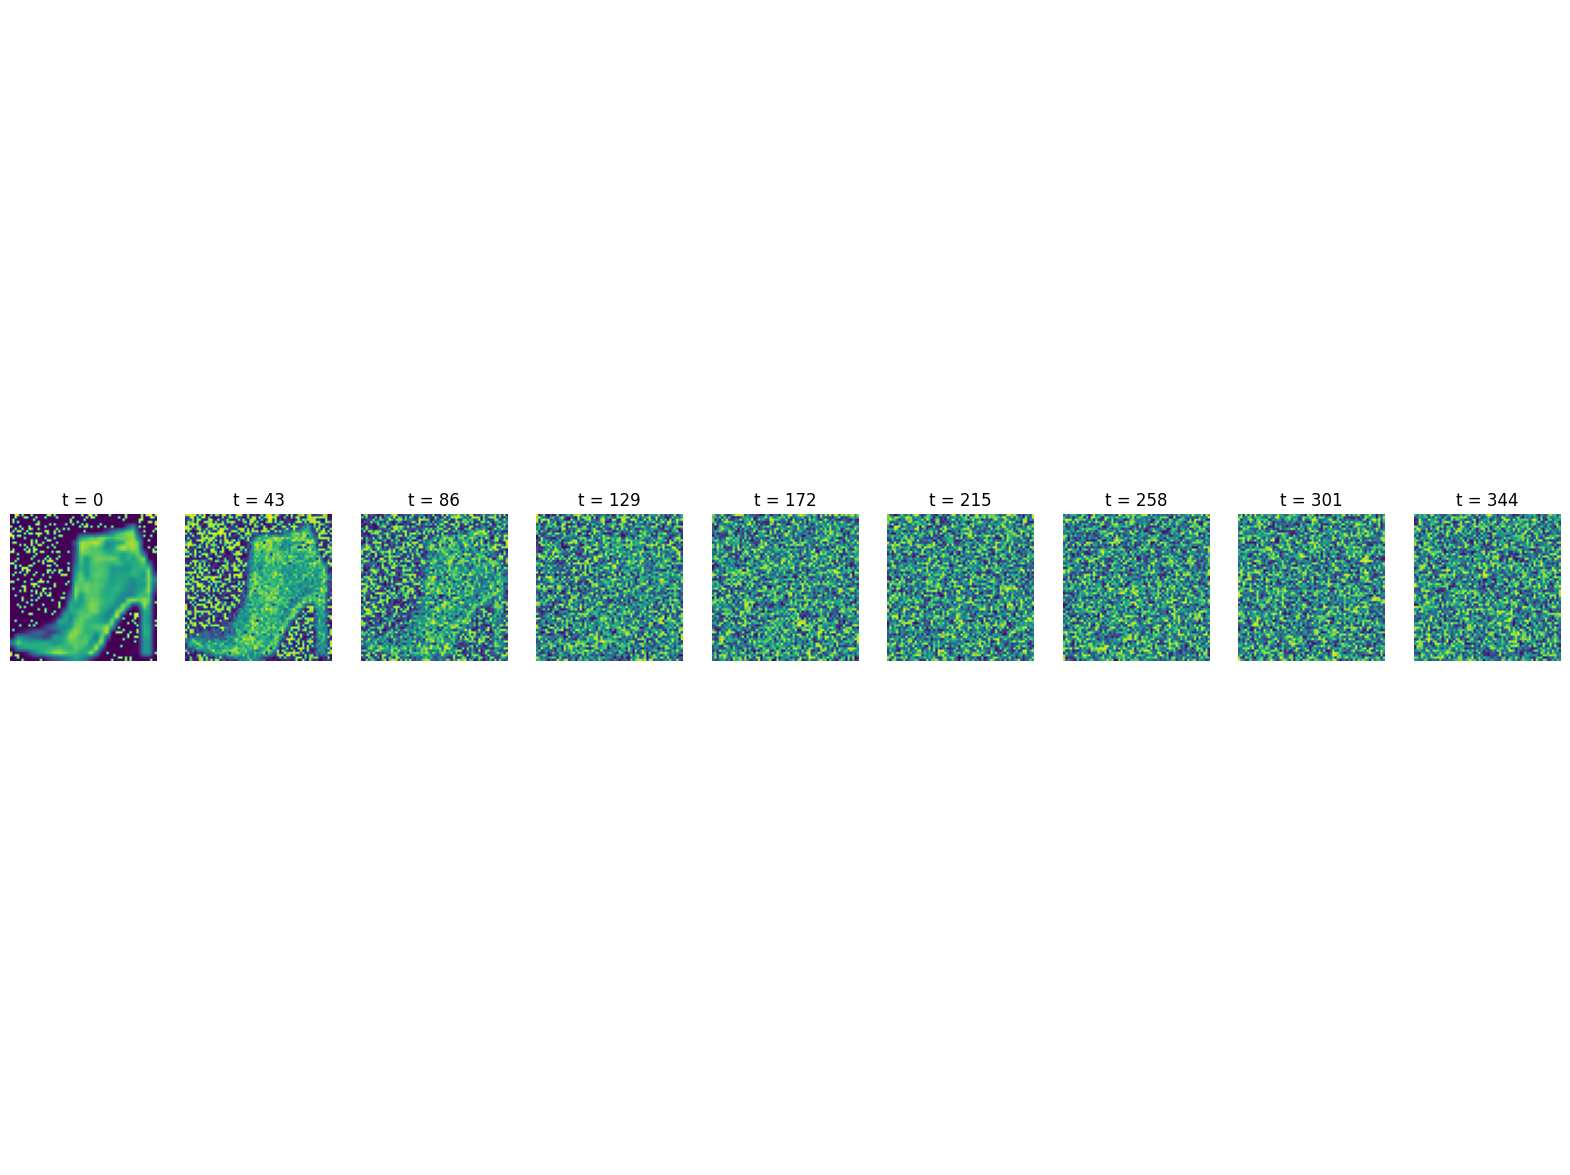

In [9]:
image = next(iter(data_loader))[0][0].to(device)

plt.figure(figsize=(20,15))
plt.axis('off')

num_images = 8
step_size = int(T/num_images)

for idx in range(0, T, step_size):
    t = torch.Tensor([idx]).type(torch.int64).to(device)
    plt.subplot(1, num_images+1, int(idx/step_size) + 1)
    
    noisy_image, noise = forward_diffusion(image, idx, alpha_cumprods)
    plt.imshow(reverse_transforms(noisy_image))
    plt.title(f't = {idx}')
    plt.axis('off')

In [10]:
# This U-Net architecture has been adapted from https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the U-Net architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)


In [11]:
model = SimpleUnet()
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

Number of parameters:  62438883


We will compute the loss as the authors did in the original paper, which is a simple MSE loss:
<p align="center">
    <img src="./images/loss_equation.png" width=35%> 
</p>
<p align="center">
    Source: <i>Denoising Diffusion Probabilistic Models</i> paper
</p>

In [12]:
def get_loss(model, x_0, t):
    x_t, noise = forward_diffusion(x_0, t, alpha_cumprods)
    pred_noise = model(x_t, t)

    return torch.mean((pred_noise - noise)**2)


In the following block, the sampling procedure is implemented as discussed in the original paper.
<p align="center">
    <img src="./images/sampling.png" width=35%> 
</p>
<p align="center">
    Source: <i>Denoising Diffusion Probabilistic Models</i> paper
</p>

In [13]:
@torch.no_grad()
def sample_timestep(x_t, t, alpha_cumprods):
    if t == 0:
        alpha_t = alpha_cumprods[0]
        z = 0
    else:
        alpha_t = alpha_cumprods[t] / alpha_cumprods[t-1]
        z = torch.randn_like(x_t, device=device) # Sample noise from a normal distribution

    alphas_cumprod_prev = torch.nn.functional.pad(alpha_cumprods[:-1], (1, 0), value=1.0)
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alpha_cumprods)
    posterior_variance_t = posterior_variance[t].to(device)
    pred_noise = model(x_t, t)
    prev_x = (x_t - (1-alpha_t)/torch.sqrt(1-alpha_cumprods[t])*pred_noise)/torch.sqrt(alpha_t) + z*torch.sqrt(posterior_variance_t)

    return prev_x
    

@torch.no_grad()
def sample_plot_image(return_final=False):
    imgs = [] # store images during denoising
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    
    num_images = 8 # number of images to plot
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t, alpha_cumprods)
        if return_final and i == 0: # we already got x_0
            return reverse_transforms(img.detach().cpu().squeeze())
        if i % stepsize == 0:
            imgs.append(reverse_transforms(img.detach().cpu().squeeze()))

    return imgs

In [14]:
import wandb

In [15]:
model.to(device)
optimizer = Adam(model.parameters(), lr=0.01)
epochs = 10


for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for step, batch in enumerate(data_loader):
        optimizer.zero_grad()

        batch = batch[0].to(device)
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long().to(device)
        loss = get_loss(model, batch, t)
        epoch_loss += loss.detach().cpu().item()
        
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch} | Loss: {epoch_loss/len(data_loader)} ", end="\r")
    
    model.eval()
    imgs = sample_plot_image()
    wandb.log({
        "epoch_loss": epoch_loss/len(data_loader),
        "images": [wandb.Image(img) for img in imgs]
    })

RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[1, 128, 64, 64] to have 3 channels, but got 128 channels instead

In [ ]:
model.eval()
imgs = sample_plot_image()

In [ ]:
# plot images
fig, axs = plt.subplots(1, len(imgs), figsize=(20, 20))
for i, img in enumerate(imgs):
    axs[i].imshow(img)
    axs[i].axis('off')
plt.show()


In [ ]:
torch.save(model.state_dict(), "model.pt")